# Model Evaluation after HPO

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os, time
import multiprocessing
from joblib import Parallel, delayed
import tensorflow as tf 

from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import predict_from_model as pfm 
from atomsci.ddm.pipeline import compare_models as cm 
from atomsci.ddm.utils import curate_data as cd
from sklearn.metrics import r2_score

sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 150)

print("Imports Done.")

Imports Done.


In [47]:
target = 'CYP2D6'

In [48]:
data_dir = '/mnt/projects/ATOM/sarkart4/Data/'+ target + '-ampl-1.1.0_old/'
outdir = '/mnt/projects/ATOM/sarkart4/Data/HPO_models_'+ target + '_old/'
curated_dir = '/mnt/projects/ATOM/sarkart4/Data/'+ target + '-Curated/'
#!ls $outdir

In [49]:
perf_df = cm.get_summary_perf_tables(collection_names=None, filter_dict={}, result_dir=outdir, prediction_type='regression', verbose=False)
#perf_df = perf_df[perf_df.rf_estimators!=500]
perf_df = perf_df.sort_values(by="valid_r2_score", ascending=False)
perf_df.to_csv(outdir+'perf_df.csv', index=False)

In [50]:
print(perf_df.shape)
perf_df.head(2)

(745, 43)


,collection,ampl_version,model_uuid,time_built,model_type,featurizer,features,transformer,splitter,split_strategy,split_uuid,umap_dim,umap_targ_wt,umap_neighbors,umap_min_dist,dataset_bucket,dataset_key,dataset_size,parameter,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,model_parameters_dict,feat_parameters_dict,train_size,train_r2_score,train_mae_score,train_rms_score,valid_size,valid_r2_score,valid_mae_score,valid_rms_score,test_size,test_r2_score,test_mae_score,test_rms_score
132,/mnt/projects/ATOM/sarkart4/Data/HPO_models_CY...,1.4.0,cae5358b-3792-4c86-85af-f199e159c8cf,1.662759e+09,RF,ecfp,ecfp,normalization,scaffold,train_valid_test,c391ef72-9cd5-4bb7-a88e-9c55be5012a9,NaN,NaN,NaN,NaN,public,/mnt/projects/ATOM/sarkart4/Data/CYP2D6-ampl-1...,10445,pIC50,NaN,NaN,NaN,NaN,NaN,256.0,64.0,128.0,NaN,NaN,"{""rf_estimators"": 256, ""rf_max_depth"": 128, ""r...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}",8876,0.922680,0.137632,0.219756,1566,0.236583,0.451190,0.659740,3,0.270269,1.045955,1.228132
190,/mnt/projects/ATOM/sarkart4/Data/HPO_models_CY...,1.4.0,3d1c8db6-1585-4804-8c64-49f81970f408,1.662761e+09,RF,ecfp,ecfp,normalization,scaffold,train_valid_test,c391ef72-9cd5-4bb7-a88e-9c55be5012a9,NaN,NaN,NaN,NaN,public,/mnt/projects/ATOM/sarkart4/Data/CYP2D6-ampl-1...,10445,pIC50,NaN,NaN,NaN,NaN,NaN,512.0,64.0,256.0,NaN,NaN,"{""rf_estimators"": 512, ""rf_max_depth"": 256, ""r...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}",8876,0.923579,0.136383,0.218475,1566,0.232021,0.452646,0.661708,3,0.266967,1.058036,1.230907


In [51]:
perf_df_slice=perf_df[['model_type','featurizer','features','splitter','train_r2_score','valid_r2_score','rf_estimators','rf_max_features','rf_max_depth','layer_sizes','dropouts','best_epoch','learning_rate']]
perf_df_slice.to_csv(outdir+'perf_df_slice.csv',index=False)
perf_df_slice

,model_type,featurizer,features,splitter,train_r2_score,valid_r2_score,rf_estimators,rf_max_features,rf_max_depth,layer_sizes,dropouts,best_epoch,learning_rate
132,RF,ecfp,ecfp,scaffold,0.922680,2.365835e-01,256.0,64.0,128.0,NaN,NaN,NaN,NaN
190,RF,ecfp,ecfp,scaffold,0.923579,2.320205e-01,512.0,64.0,256.0,NaN,NaN,NaN,NaN
206,RF,ecfp,ecfp,scaffold,0.918995,2.313480e-01,256.0,32.0,64.0,NaN,NaN,NaN,NaN
41,RF,ecfp,ecfp,scaffold,0.920773,2.304568e-01,512.0,64.0,64.0,NaN,NaN,NaN,NaN
46,RF,ecfp,ecfp,scaffold,0.923611,2.304268e-01,512.0,128.0,128.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,NN,graphconv,graphconv,scaffold,0.121776,3.812478e-02,NaN,NaN,NaN,"512,256,128","0.50,0.50,0.50",8.0,0.0007
743,NN,computed_descriptors,mordred_filtered,scaffold,0.008857,5.860912e-03,NaN,NaN,NaN,"512,256,128,64","0.50,0.50,0.50,0.50",0.0,0.0050
14,NN,ecfp,ecfp,scaffold,-0.000075,-5.357997e-07,NaN,NaN,NaN,"512,256,32","0.50,0.50,0.50",16.0,0.0050
735,NN,computed_descriptors,mordred_filtered,scaffold,-0.001761,-1.660120e-04,NaN,NaN,NaN,"512,256,32","0.50,0.50,0.50",0.0,0.0050


In [52]:
perf_df.shape

(745, 43)

In [53]:
perf_df.groupby(by=['model_type', 'features']).count()[['model_uuid']].T

model_type   NN                                        RF                   \
features   ecfp graphconv mordred_filtered rdkit_raw ecfp mordred_filtered   
model_uuid   38        16               28        32  211              210   

model_type            
features   rdkit_raw  
model_uuid       210

In [54]:
rfmods = perf_df[perf_df.model_type=="RF"]
print(rfmods.shape)
print(rfmods.head(1)['valid_r2_score'])
rfmods[['model_type','featurizer','features','splitter','train_r2_score','valid_r2_score','rf_estimators','rf_max_features','rf_max_depth']]
#rfmods.head(10)

(631, 43)
132    0.236583
Name: valid_r2_score, dtype: float64


,model_type,featurizer,features,splitter,train_r2_score,valid_r2_score,rf_estimators,rf_max_features,rf_max_depth
132,RF,ecfp,ecfp,scaffold,0.922680,0.236583,256.0,64.0,128.0
190,RF,ecfp,ecfp,scaffold,0.923579,0.232021,512.0,64.0,256.0
206,RF,ecfp,ecfp,scaffold,0.918995,0.231348,256.0,32.0,64.0
41,RF,ecfp,ecfp,scaffold,0.920773,0.230457,512.0,64.0,64.0
46,RF,ecfp,ecfp,scaffold,0.923611,0.230427,512.0,128.0,128.0
...,...,...,...,...,...,...,...,...,...
331,RF,computed_descriptors,rdkit_raw,scaffold,0.898822,0.131703,16.0,16.0,32.0
473,RF,computed_descriptors,mordred_filtered,scaffold,0.893024,0.130207,16.0,32.0,64.0
454,RF,computed_descriptors,mordred_filtered,scaffold,0.893190,0.126769,16.0,32.0,128.0
146,RF,ecfp,ecfp,scaffold,0.474645,0.126370,16.0,16.0,16.0


In [55]:
nnmods = perf_df[perf_df.model_type=="NN"]
print(nnmods.shape)
print(nnmods.head(1)['valid_r2_score'])
nnmods[['model_type','featurizer','features','splitter','train_r2_score','valid_r2_score','layer_sizes','dropouts','best_epoch','learning_rate']].head(100)

#nnmods.head(5)

(114, 43)
15    0.21124
Name: valid_r2_score, dtype: float64


,model_type,featurizer,features,splitter,train_r2_score,valid_r2_score,layer_sizes,dropouts,best_epoch,learning_rate
15,NN,ecfp,ecfp,scaffold,0.664887,0.211240,"256,64","0.30,0.30",4.0,0.0050
0,NN,ecfp,ecfp,scaffold,0.671560,0.211221,"512,128","0.50,0.50",13.0,0.0050
5,NN,ecfp,ecfp,scaffold,0.728206,0.204688,"128,32","0.50,0.50",20.0,0.0050
29,NN,ecfp,ecfp,scaffold,0.775481,0.201950,"128,32","0.30,0.30",10.0,0.0050
37,NN,ecfp,ecfp,scaffold,0.796605,0.201182,"256,64,16","0.30,0.30,0.30",29.0,0.0050
...,...,...,...,...,...,...,...,...,...,...
680,NN,graphconv,graphconv,scaffold,0.197382,0.087698,"256,64,16","0.50,0.50,0.50",25.0,0.0007
681,NN,graphconv,graphconv,scaffold,0.163813,0.085194,"512,256,128","0.50,0.50,0.50",11.0,0.0050
719,NN,computed_descriptors,rdkit_raw,scaffold,0.146599,0.081895,"512,128,128","0.50,0.50,0.50",18.0,0.0050
689,NN,computed_descriptors,mordred_filtered,scaffold,0.128226,0.075205,"256,64,16","0.50,0.50,0.50",1.0,0.0050


In [56]:
xgboostmods = perf_df[perf_df.model_type=="xgboost"]
print(xgboostmods.shape)
print(xgboostmods.head(1)['valid_r2_score'])
xgboostmods.head(2)

(0, 43)
Series([], Name: valid_r2_score, dtype: float64)


,collection,ampl_version,model_uuid,time_built,model_type,featurizer,features,transformer,splitter,split_strategy,split_uuid,umap_dim,umap_targ_wt,umap_neighbors,umap_min_dist,dataset_bucket,dataset_key,dataset_size,parameter,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,model_parameters_dict,feat_parameters_dict,train_size,train_r2_score,train_mae_score,train_rms_score,valid_size,valid_r2_score,valid_mae_score,valid_rms_score,test_size,test_r2_score,test_mae_score,test_rms_score


In [57]:
# should be 10 each, 20 groups per feature, if you got all the models created
nnmods.groupby(by=['features','layer_sizes','dropouts']).count()[['model_uuid']]

model_uuid
features  layer_sizes    dropouts                       
ecfp      128,32         0.00,0.00                     2
                         0.30,0.30                     2
                         0.50,0.50                     2
          256,64         0.00,0.00                     2
                         0.30,0.30                     2
...                                                  ...
rdkit_raw 512,256,128    0.00,0.00,0.00                2
                         0.50,0.50,0.50                2
          512,256,128,64 0.50,0.50,0.50,0.50           4
          512,256,32     0.00,0.00,0.00                2
                         0.50,0.50,0.50                2

[55 rows x 1 columns]

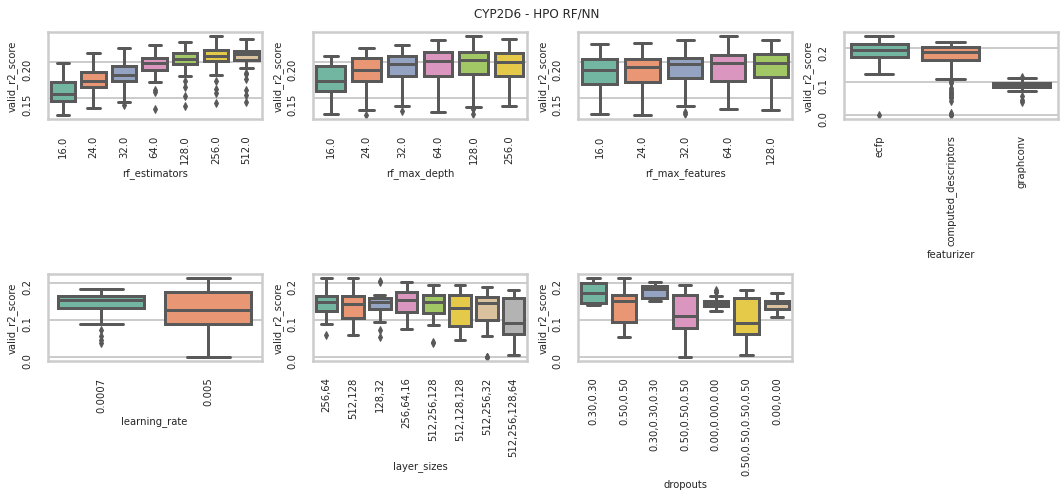

In [58]:
#visual of HPO results
plt.rc('font', size=10)          # controls default text size
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels

fig, ax = plt.subplots(2,4,figsize=(15,7))
fig.suptitle(target+ " - HPO RF/NN")
sns.boxplot(data=perf_df, x="rf_estimators", y="valid_r2_score", ax=ax[0][0])
sns.boxplot(data=perf_df, x="rf_max_depth", y="valid_r2_score", ax=ax[0][1])
sns.boxplot(data=perf_df, x="rf_max_features", y="valid_r2_score", ax=ax[0][2])
sns.boxplot(data=perf_df, x="featurizer", y="valid_r2_score", ax=ax[0][3])

sns.boxplot(data=perf_df, x="learning_rate", y="valid_r2_score", ax=ax[1][0])
sns.boxplot(data=perf_df, x="layer_sizes", y="valid_r2_score", ax=ax[1][1])
sns.boxplot(data=perf_df, x="dropouts", y="valid_r2_score", ax=ax[1][2])
ax[0][0].tick_params(labelrotation=90)
ax[0][1].tick_params(labelrotation=90)
ax[0][2].tick_params(labelrotation=90)
ax[0][3].tick_params(labelrotation=90)
ax[1][0].tick_params(labelrotation=90)
ax[1][1].tick_params(labelrotation=90)
ax[1][2].tick_params(labelrotation=90)
fig.tight_layout()
fig.delaxes(ax= ax[1,3]) # delete last empty plot (as we have plotted 7 params (2 row, 4 col), not 8)

In [59]:
# #visual of RF HPO results
# fig, ax = plt.subplots(1,4,figsize=(21,7))
# sns.boxplot(data=perf_df, x="rf_estimators", y="valid_r2_score", ax=ax[0])
# sns.boxplot(data=perf_df, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
# sns.boxplot(data=perf_df, x="rf_max_features", y="valid_r2_score", ax=ax[2])
# sns.boxplot(data=perf_df, x="featurizer", y="valid_r2_score", ax=ax[3])
# fig.tight_layout()

In [60]:
#  #visual of NN HPO results
# fig, ax =plt.subplots(1,4,figsize=(21,7))
# sns.boxplot(data=perf_df, x="learning_rate", y="valid_r2_score", ax=ax[0])
# sns.boxplot(data=perf_df, x="layer_sizes", y="valid_r2_score", ax=ax[1])
# sns.boxplot(data=perf_df, x="dropouts", y="valid_r2_score", ax=ax[2])
# sns.boxplot(data=perf_df, x="featurizer", y="valid_r2_score", ax=ax[3])
# fig.tight_layout()

# Predict from model using best model

### 1. Select the best model (from trained models, based on top valid_r2_score)

In [61]:
model_uuid = perf_df.head(1)['model_uuid'].tolist()[0] # best model, note: perf_df is sorted in desccending order
model_uuid

'cae5358b-3792-4c86-85af-f199e159c8cf'

In [62]:
from atomsci.ddm.pipeline import predict_from_model as pfm
import time
from sklearn.metrics import r2_score

In [63]:
# get best model
tarball = outdir+ target.lower()+'_union_trainset_base_smiles_model_'+model_uuid+'.tar.gz' 
if os.path.exists(tarball):print("model tarball found");
response_col = 'pIC50'
tarball

model tarball found


'/mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz'

### 2. Predict on union_test

In [64]:
union_test_file = data_dir+ target.lower()+"_union_testset_base_smiles.csv"
union_test = pd.read_csv(union_test_file) 
if os.path.exists(union_test_file):print("union_test data found");
union_test.head(2)

union_test data found


,base_rdkit_smiles,compound_id,pIC50,relation,active
0,S=C(Nc1ccc2cn[nH]c2c1)Nc1ccc2cn[nH]c2c1,OTJWJLLGPAFTIP-KNLWZTMUNA-N,5.7,NaN,1
1,Cc1[nH]c2ccccc2c1C(c1ccccn1)N1CCC(C)CC1,NBKDMBGWUXYCJB-UHFFFAOYNA-N,4.6,<,0


In [65]:
start=time.time()
union_test_pred_df = pfm.predict_from_model_file(tarball, # model used for prediction, input format=tar.gz
                                            union_test, # unseen data, format=csv
                                            id_col='compound_id',
                                            smiles_col='base_rdkit_smiles',
                                            response_col='pIC50',
                                            conc_col=None,
                                            is_featurized=False,
                                            dont_standardize=True,
                                            AD_method='z_score',
                                            k=5,
                                            dist_metric='euclidean',
                                            external_training_data=None)
union_test_pred_df.to_csv(outdir+target+'union_test_pred_df_using_best_model.csv')
print(time.time()-start)
union_test_r2=round(r2_score(y_true=union_test_pred_df[f'{response_col}_actual'], y_pred=union_test_pred_df[f'{response_col}_pred']), 3)
union_test_r2

INFO:atomsci.ddm.utils.model_version_utils:/mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz, 1.4.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz version = "1.4.0", AMPL version = "1.4.0"


num_model_tasks is deprecated and its value is ignored.
Featurization = DynamicFeaturization with ecfp features
number of features: 1024
Featurizing training data for AD calculation.
number of features: 1024
Calculating AD index.
number of features: 1024
42.39063382148743


0.431

In [66]:
union_test_pred_df.head(2)

,base_rdkit_smiles,compound_id,pIC50,relation,active,pIC50_actual,pIC50_pred,pIC50_std,AD_index
0,S=C(Nc1ccc2cn[nH]c2c1)Nc1ccc2cn[nH]c2c1,OTJWJLLGPAFTIP-KNLWZTMUNA-N,5.7,NaN,1,5.7,5.143797,0.654045,1.429730
1,Cc1[nH]c2ccccc2c1C(c1ccccn1)N1CCC(C)CC1,NBKDMBGWUXYCJB-UHFFFAOYNA-N,4.6,<,0,4.6,5.243888,0.833574,2.197562


### 3.a. Predict on raw dtc

In [67]:
start=time.time()
# dtc_raw from MoDaC - I have curated the data and used curated file saved at ./../Data/CYP3A4-Curated/CYP3A4_dtc_smiles_curated.csv
#dtc_raw_file=data_dir+target.lower()+'_dtc_smiles.csv'
dtc_raw_file=curated_dir+target+'_dtc_smiles_curated.csv'
if os.path.exists(dtc_raw_file):print(dtc_raw_file);
dtc_raw_df=pd.read_csv(dtc_raw_file)
dtc_raw_df.head(2)
#dtc_raw_df.standard_relation
#dtc_raw_df.PIC50

/mnt/projects/ATOM/sarkart4/Data/CYP2D6-Curated/CYP2D6_dtc_smiles_curated.csv


,compound_id,base_rdkit_smiles,relation,PIC50,active
0,SWWRPROUTDGFFV-UHFFFAOYSA-N,CCS(=O)(=O)CCc1c(Cn2c(=O)n(C3CC3)c3ccncc32)nc2...,>,4.30103,0
1,FBZXCTCJIZJFCP-UHFFFAOYSA-N,COc1ccc2[nH]cc(CC(C)(C)NCC(O)COc3ccccc3C#N)c2c1,NaN,7.30103,1


In [68]:
response_col = 'pIC50'
dtc_raw_pred_df = pfm.predict_from_model_file(tarball, # model used for prediction, input format=tar.gz
                                            dtc_raw_df, # unseen data, format=csv
                                            id_col='compound_id',
                                            smiles_col='base_rdkit_smiles',
                                            response_col='PIC50',
                                            conc_col=None,
                                            is_featurized=False,
                                            dont_standardize=True,
                                            AD_method='z_score',
                                            k=5,
                                            dist_metric='euclidean',
                                            external_training_data=None)
dtc_raw_pred_df.to_csv(outdir+target+'dtc_raw_pred_df_using_best_model.csv')
print(time.time()-start)
dtc_raw_r2=round(r2_score(y_true=dtc_raw_pred_df[f'{response_col}_actual'], y_pred=dtc_raw_pred_df[f'{response_col}_pred']), 3)
dtc_raw_r2

INFO:atomsci.ddm.utils.model_version_utils:/mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz, 1.4.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz version = "1.4.0", AMPL version = "1.4.0"


num_model_tasks is deprecated and its value is ignored.
Featurization = DynamicFeaturization with ecfp features
number of features: 1024
Featurizing training data for AD calculation.
number of features: 1024
Calculating AD index.
number of features: 1024
51.304726123809814


0.844

### 3.b. Predict on dtc_test

In [69]:
# from MoDac, it was curated and uploaded
start=time.time()
dtc_test_file = data_dir+ target.lower()+"_dtc_testset_base_smiles_union.csv"
dtc_test = pd.read_csv(dtc_raw_file) 
if os.path.exists(dtc_test_file):print("dtc test data found");
dtc_test.head(2)

dtc test data found


,compound_id,base_rdkit_smiles,relation,PIC50,active
0,SWWRPROUTDGFFV-UHFFFAOYSA-N,CCS(=O)(=O)CCc1c(Cn2c(=O)n(C3CC3)c3ccncc32)nc2...,>,4.30103,0
1,FBZXCTCJIZJFCP-UHFFFAOYSA-N,COc1ccc2[nH]cc(CC(C)(C)NCC(O)COc3ccccc3C#N)c2c1,NaN,7.30103,1


In [70]:
# response_col = 'pIC50'
dtc_test_pred_df = pfm.predict_from_model_file(tarball, # model used for prediction, input format=tar.gz
                                            dtc_test, # unseen data, format=csv
                                            id_col='compound_id',
                                            smiles_col='base_rdkit_smiles',
                                            response_col='PIC50',
                                            conc_col=None,
                                            is_featurized=False,
                                            dont_standardize=True,
                                            AD_method='z_score',
                                            k=5,
                                            dist_metric='euclidean',
                                            external_training_data=None)
dtc_test_pred_df.to_csv(outdir+target+'dtc_test_pred_df_using_best_model.csv')
print(time.time()-start)

dtc_test_r2=round(r2_score(y_true=dtc_test_pred_df[f'{response_col}_actual'], y_pred=dtc_test_pred_df[f'{response_col}_pred']), 3)
dtc_test_r2

INFO:atomsci.ddm.utils.model_version_utils:/mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz, 1.4.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz version = "1.4.0", AMPL version = "1.4.0"


num_model_tasks is deprecated and its value is ignored.
Featurization = DynamicFeaturization with ecfp features
number of features: 1024
Featurizing training data for AD calculation.
number of features: 1024
Calculating AD index.
number of features: 1024
51.5497784614563


0.844

### 4.a. prediction on Excape raw

In [71]:
start=time.time()
# excape_raw from MoDaC - I have curated the data and used curated file saved at ./../Data/CYP3A4-Curated/CYP3A4_excape_smiles_curated.csv
#dtc_raw_file=data_dir+target.lower()+'_dtc_smiles.csv'
#excape_raw_file = data_dir+ target.lower()+"_excape_smiles.csv"
excape_raw_file = curated_dir+ target+"_excape_smiles_curated.csv"
excape_raw = pd.read_csv(excape_raw_file) 
print(excape_raw.shape)
if os.path.exists(excape_raw_file):print("excape raw data found");
excape_raw = excape_raw[~excape_raw.rdkit_smiles.isna()] 
print(excape_raw.columns)
print(excape_raw.shape)
excape_raw.head(2)

(7892, 17)
excape raw data found
Index(['Ambit_InchiKey', 'compound_id', 'Entrez_ID', 'Activity_Flag', 'pIC50',
       'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol', 'Ortholog_Group',
       'InChI', 'SMILES', 'rdkit_smiles', 'VALUE_NUM_mean', 'VALUE_NUM_std',
       'Perc_Var', 'Remove_BadDuplicate'],
      dtype='object')
(7891, 17)


,Ambit_InchiKey,compound_id,Entrez_ID,Activity_Flag,pIC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,InChI,SMILES,rdkit_smiles,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,AABYLPRACHMDSN-CIQXGXBCNA-N,CHEMBL1593731,1565,A,5.80000,chembl20,737822,9606,CYP2D6,un13,InChI=1/C26H32N2O3/c1-18(24(29)27-16-19-13-14-...,O=C(NCC1CC1)[C@@H]([C@@H]2[C@](C2)([C@H](NC(OC...,C[C@@H](C(=O)NCC1CC1)[C@H]1C[C@]1(C)[C@H](NC(=...,5.80000,NaN,0.0,0
1,AABYLPRACHMDSN-TWWBEHSRNA-N,3247293,1565,A,6.10002,pubchem,891,9606,CYP2D6,un13,InChI=1/C26H32N2O3/c1-18(24(29)27-16-19-13-14-...,O=C(NCC1CC1)[C@@H]([C@H]2[C@@](C2)([C@@H](NC(O...,C[C@@H](C(=O)NCC1CC1)[C@@H]1C[C@@]1(C)[C@@H](N...,6.10002,NaN,0.0,0


In [72]:
response_col = 'pIC50'
excape_raw_pred_df = pfm.predict_from_model_file(tarball, # model used for prediction, input format=tar.gz
                                            excape_raw, # unseen data, format=csv
                                            id_col='Original_Entry_ID', # ???
                                            smiles_col='rdkit_smiles',
                                            response_col='pIC50',
                                            conc_col=None,
                                            is_featurized=False,
                                            dont_standardize=True,
                                            AD_method='z_score',
                                            #k=5,
                                            dist_metric='euclidean',
                                            external_training_data=None)
excape_raw_pred_df.to_csv(outdir+target+'excape_raw_pred_df_using_best_model.csv')
print(time.time()-start)
excape_raw_r2=round(r2_score(y_true=excape_raw_pred_df[f'{response_col}_actual'], y_pred=excape_raw_pred_df[f'{response_col}_pred']), 3)
excape_raw_r2

INFO:atomsci.ddm.utils.model_version_utils:/mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz, 1.4.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz version = "1.4.0", AMPL version = "1.4.0"


num_model_tasks is deprecated and its value is ignored.
Featurization = DynamicFeaturization with ecfp features
number of features: 1024
Featurizing training data for AD calculation.
Cannot find original training data, AD not calculated
40.90812110900879


0.699

### 4.b. prediction on Excape test

In [73]:
start=time.time()
excape_test_file = data_dir+target.lower()+"_excape_testset_base_smiles_union.csv" # note: filename mixed upper and lower case
excape_test = pd.read_csv(excape_test_file) 
if os.path.exists(excape_test_file):print("excape test data found");
print(excape_test.columns)
excape_test.head(2)

excape test data found
Index(['base_rdkit_smiles', 'compound_id', 'pIC50', 'relation', 'active'], dtype='object')


,base_rdkit_smiles,compound_id,pIC50,relation,active
0,COCCCNC(=O)C1CCC(=O)N1Cc1ccccc1Cl,SLQVVKYIMOJGIK-GPQMBLKYNA-N,4.6,<,0
1,Cc1ccc(CC(=O)N2CCN(c3cccc(C(F)(F)F)c3)CC2)cc1,SBUISHYOUSIRIU-UHFFFAOYNA-N,4.5,<,0


In [74]:
response_col = 'pIC50'
excape_test_pred_df = pfm.predict_from_model_file(tarball, # model used for prediction, input format=tar.gz
                                            excape_test, # unseen data, format=csv
                                            id_col='compound_id',
                                            smiles_col='base_rdkit_smiles',
                                            response_col='pIC50',
                                            conc_col=None,
                                            is_featurized=False,
                                            dont_standardize=True,
                                            AD_method='z_score',
                                            k=5,
                                            dist_metric='euclidean',
                                            external_training_data=None)
excape_test_pred_df.to_csv(outdir+target+'excape_test_pred_df_using_best_model.csv')
print(time.time()-start)
excape_test_r2=round(r2_score(y_true=excape_test_pred_df[f'{response_col}_actual'], y_pred=excape_test_pred_df[f'{response_col}_pred']), 3)
excape_test_r2

INFO:atomsci.ddm.utils.model_version_utils:/mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz, 1.4.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz version = "1.4.0", AMPL version = "1.4.0"


num_model_tasks is deprecated and its value is ignored.
Featurization = DynamicFeaturization with ecfp features
number of features: 1024
Featurizing training data for AD calculation.
number of features: 1024
Calculating AD index.
number of features: 1024
40.38132119178772


0.713

# 5. Prediction on DIFFEERENT dataset 
 I used the CYP3A4 model to predict on raw dataset of CYP2D6 etc, also, CHRM1 etc. 
 
 
 Same is done for other two CYP models -  CYP2D6 and CYP2C9

In [75]:
data_dir_all = '/home/sarkart4/MoDaC/NCI_DOE_Archive/ATOM/Safety_Screen_Targets/'
#!ls $data_dir_all

In [120]:
#chrm1_dtc_raw = pd.read_csv(data_dir_all+ 'CHRM1-ampl-1.1.0/chrm1_dtc_smiles.csv') # compound_id, rdkit_smiles
chrm1_dtc_raw = pd.read_csv('/mnt/projects/ATOM/sarkart4/Data/CHRM1-Curated/CHRM1_dtc_smiles_curated.csv')
chrm2_dtc_raw = pd.read_csv(data_dir_all+ 'CHRM2-ampl-1.1.0/chrm2_dtc_base_smiles_all.csv') # compound_id, base_rdkit_smiles, PIC50
chrm3_dtc_raw = pd.read_csv(data_dir_all+ 'CHRM3-ampl-1.1.0/chrm3_dtc_smiles.csv') # compound_id, rdkit_smiles
# use curated data
#cyp3a4_dtc_raw = pd.read_csv(data_dir_all+ 'CYP3A4-ampl-1.1.0/cyp3a4_dtc_smiles.csv') # compound_id, rdkit_smiles
cyp3a4_dtc_raw = pd.read_csv('/mnt/projects/ATOM/sarkart4/Data/CYP3A4-Curated/CYP3A4_dtc_smiles_curated.csv')
# cyp2d6 raw data do not have any pIC50 column, therefore, I am using the curated data
#cyp2d6_dtc_raw = pd.read_csv(data_dir_all+ 'CYP2D6-ampl-1.1.0/cyp2d6_dtc_smiles.csv') # compound_id, rdkit_smiles
cyp2d6_dtc_raw = pd.read_csv('/mnt/projects/ATOM/sarkart4/Data/CYP2D6-Curated/CYP2D6_dtc_smiles_curated.csv')
# use raw data
#cyp2c9_dtc_raw = pd.read_csv(data_dir_all+ 'CYP2C9-ampl-1.1.0/cyp2c9_dtc_smiles.csv') # compound_id, rdkit_smiles
cyp2c9_dtc_raw = pd.read_csv('/mnt/projects/ATOM/sarkart4/Data/CYP2C9-Curated/CYP2C9_dtc_smiles_curated.csv')
hrh1_dtc_raw = pd.read_csv(data_dir_all+ 'HRH1-ampl-1.1.0/hrh1_dtc_smiles.csv') # compound_id, rdkit_smiles
kcnh2_dtc_raw = pd.read_csv(data_dir_all+ 'KCNH2-ampl-1.1.0/kcnh2_dtc_smiles.csv') # compound_id, rdkit_smiles
pik3cg_dtc_raw = pd.read_csv(data_dir_all+ 'PIK3CG-ampl-1.1.0/pik3cg_dtc_smiles.csv') # compound_id, rdkit_smiles
#pik3cg_dtc_raw.head(2)

In [78]:
#chrm1_excape_raw = pd.read_csv(data_dir_all+ 'CHRM1-ampl-1.1.0/chrm1_excape_smiles.csv') # compound_id, rdkit_smiles
chrm1_excape_raw = pd.read_csv('/mnt/projects/ATOM/sarkart4/Data/CHRM1-Curated/CHRM1_excape_smiles_curated.csv')
chrm2_excape_raw = pd.read_csv(data_dir_all+ 'CHRM2-ampl-1.1.0/chrm2_excape_smiles.csv') # compound_id, base_rdkit_smiles, PIC50
chrm3_excape_raw = pd.read_csv(data_dir_all+ 'CHRM3-ampl-1.1.0/chrm3_excape_smiles.csv') # compound_id, rdkit_smiles
#cyp3a4_excape_raw = pd.read_csv(data_dir_all+ 'CYP3A4-ampl-1.1.0/cyp3a4_excape_smiles.csv') # compound_id, rdkit_smiles
cyp3a4_excape_raw = pd.read_csv('/mnt/projects/ATOM/sarkart4/Data/CYP3A4-Curated/CYP3A4_excape_smiles_curated.csv')
#cyp2d6_excape_raw = pd.read_csv(data_dir_all+ 'CYP2D6-ampl-1.1.0/cyp2d6_excape_smiles.csv') # compound_id, rdkit_smiles
cyp2d6_excape_raw = pd.read_csv('/mnt/projects/ATOM/sarkart4/Data/CYP2D6-Curated/CYP2D6_excape_smiles_curated.csv')
#cyp2c9_excape_raw = pd.read_csv(data_dir_all+ 'CYP2C9-ampl-1.1.0/cyp2c9_excape_smiles.csv') # compound_id, rdkit_smiles
cyp2c9_excape_raw = pd.read_csv('/mnt/projects/ATOM/sarkart4/Data/CYP2C9-Curated/CYP2C9_excape_smiles_curated.csv')
hrh1_excape_raw = pd.read_csv(data_dir_all+ 'HRH1-ampl-1.1.0/hrh1_excape_smiles.csv') # compound_id, rdkit_smiles
kcnh2_excape_raw = pd.read_csv(data_dir_all+ 'KCNH2-ampl-1.1.0/kcnh2_excape_smiles.csv') # compound_id, rdkit_smiles
pik3cg_excape_raw = pd.read_csv(data_dir_all+ 'PIK3CG-ampl-1.1.0/pik3cg_excape_smiles.csv') # compound_id, rdkit_smiles
#pik3cg_excape_raw.head(2)

### Predict from model 

In [79]:
response_col = 'PIC50'
[tarball,model_uuid]

['/mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz',
 'cae5358b-3792-4c86-85af-f199e159c8cf']

In [80]:
start=time.time()
chrm1_dtc_raw_pred_df = pfm.predict_from_model_file(tarball,chrm1_dtc_raw,id_col='compound_id',smiles_col='base_rdkit_smiles',response_col='pIC50',conc_col=None,is_featurized=False,dont_standardize=True,AD_method='z_score',k=5,dist_metric='euclidean',external_training_data=None)
chrm1_dtc_raw_pred_df.to_csv(outdir+target+'chrm1_dtc_raw_pred_df_using_best_model_'+model_uuid+'.csv')
#chrm1_dtc_raw_pred_df.head(2)
print(time.time()-start)
chrm1_dtc_raw_r2=round(r2_score(y_true=chrm1_dtc_raw_pred_df['PIC50'], y_pred=chrm1_dtc_raw_pred_df['pIC50_pred']), 3)
chrm1_dtc_raw_r2

INFO:atomsci.ddm.utils.model_version_utils:/mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz, 1.4.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz version = "1.4.0", AMPL version = "1.4.0"


num_model_tasks is deprecated and its value is ignored.
Featurization = DynamicFeaturization with ecfp features
number of features: 1024
Featurizing training data for AD calculation.
number of features: 1024
Calculating AD index.
number of features: 1024
38.91560983657837


-0.514

In [81]:
start=time.time()
chrm2_dtc_raw_pred_df = pfm.predict_from_model_file(tarball,chrm2_dtc_raw,id_col='compound_id',smiles_col='base_rdkit_smiles',response_col='PIC50',conc_col=None,is_featurized=False,dont_standardize=True,AD_method='z_score',k=5,dist_metric='euclidean',external_training_data=None)
chrm2_dtc_raw_pred_df.to_csv(outdir+target+'chrm2_dtc_raw_pred_df_using_best_model_'+model_uuid+'.csv')
chrm2_dtc_raw_pred_df.head(2)
print(time.time()-start)

INFO:atomsci.ddm.utils.model_version_utils:/mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz, 1.4.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz version = "1.4.0", AMPL version = "1.4.0"


num_model_tasks is deprecated and its value is ignored.
Featurization = DynamicFeaturization with ecfp features
number of features: 1024
Featurizing training data for AD calculation.
number of features: 1024
Calculating AD index.
number of features: 1024
38.19033646583557


In [82]:
chrm2_dtc_raw_r2=round(r2_score(y_true=chrm2_dtc_raw_pred_df['PIC50'], y_pred=chrm2_dtc_raw_pred_df['pIC50_pred']), 3)
chrm2_dtc_raw_r2

-0.845

In [83]:
start=time.time()
chrm3_dtc_raw_pred_df = pfm.predict_from_model_file(tarball,chrm3_dtc_raw,id_col='compound_id',smiles_col='rdkit_smiles',response_col='pIC50',conc_col=None,is_featurized=False,dont_standardize=True,AD_method='z_score',k=5,dist_metric='euclidean',external_training_data=None)
chrm3_dtc_raw_pred_df.to_csv(outdir+target+'chrm3_dtc_raw_pred_df_using_best_model_'+model_uuid+'.csv')
#chrm3_dtc_raw_pred_df.head(2)
print(time.time()-start)

INFO:atomsci.ddm.utils.model_version_utils:/mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz, 1.4.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz version = "1.4.0", AMPL version = "1.4.0"


num_model_tasks is deprecated and its value is ignored.
Featurization = DynamicFeaturization with ecfp features
number of features: 1024
Featurizing training data for AD calculation.
Cannot find original training data, AD not calculated
3.7018091678619385


In [84]:
chrm3_dtc_raw_r2=round(r2_score(y_true=chrm3_dtc_raw_pred_df['PIC50'], y_pred=chrm3_dtc_raw_pred_df['pIC50_pred']), 3)
chrm3_dtc_raw_r2

-1.085

In [85]:
start=time.time()
cyp3a4_dtc_raw_pred_df = pfm.predict_from_model_file(tarball,cyp3a4_dtc_raw,id_col='compound_id',smiles_col='base_rdkit_smiles',response_col='pIC50',conc_col=None,is_featurized=False,dont_standardize=True,AD_method='z_score',k=5,dist_metric='euclidean',external_training_data=None)
cyp3a4_dtc_raw_pred_df.to_csv(outdir+target+'cyp3a4_dtc_raw_pred_df_using_best_model_'+model_uuid+'.csv')
print(time.time()-start)

INFO:atomsci.ddm.utils.model_version_utils:/mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz, 1.4.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz version = "1.4.0", AMPL version = "1.4.0"


num_model_tasks is deprecated and its value is ignored.
Featurization = DynamicFeaturization with ecfp features
number of features: 1024
Featurizing training data for AD calculation.
number of features: 1024
Calculating AD index.
number of features: 1024
65.07965517044067


In [86]:
cyp3a4_dtc_raw_r2=round(r2_score(y_true=cyp3a4_dtc_raw_pred_df['PIC50'], y_pred=cyp3a4_dtc_raw_pred_df['pIC50_pred']), 3)
cyp3a4_dtc_raw_r2

0.088

In [87]:
start=time.time()
cyp2d6_dtc_raw_pred_df = pfm.predict_from_model_file(tarball,cyp2d6_dtc_raw,id_col='compound_id',smiles_col='base_rdkit_smiles',response_col='PIC50',conc_col=None,is_featurized=False,dont_standardize=True,AD_method='z_score',k=5,dist_metric='euclidean',external_training_data=None)
cyp2d6_dtc_raw_pred_df.to_csv(outdir+target+'cyp2d6_dtc_raw_pred_df_using_best_model_'+model_uuid+'.csv')
print(time.time()-start)

INFO:atomsci.ddm.utils.model_version_utils:/mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz, 1.4.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz version = "1.4.0", AMPL version = "1.4.0"


num_model_tasks is deprecated and its value is ignored.
Featurization = DynamicFeaturization with ecfp features
number of features: 1024
Featurizing training data for AD calculation.
number of features: 1024
Calculating AD index.
number of features: 1024
51.51071834564209


In [88]:
cyp2d6_dtc_raw_pred_df.head(2)
cyp2d6_dtc_raw_r2=round(r2_score(y_true=cyp2d6_dtc_raw_pred_df['PIC50'], y_pred=cyp2d6_dtc_raw_pred_df['pIC50_pred']), 3)
cyp2d6_dtc_raw_r2

0.844

In [89]:
start=time.time()
cyp2c9_dtc_raw_pred_df = pfm.predict_from_model_file(tarball,cyp2c9_dtc_raw,id_col='compound_id',smiles_col='base_rdkit_smiles',response_col='pIC50',conc_col=None,is_featurized=False,dont_standardize=True,AD_method='z_score',k=5,dist_metric='euclidean',external_training_data=None)
cyp2c9_dtc_raw_pred_df.to_csv(outdir+target+'cyp2c9_dtc_raw_pred_df_using_best_model_'+model_uuid+'.csv')
print(time.time()-start)

INFO:atomsci.ddm.utils.model_version_utils:/mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz, 1.4.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/cyp2d6_union_trainset_base_smiles_model_cae5358b-3792-4c86-85af-f199e159c8cf.tar.gz version = "1.4.0", AMPL version = "1.4.0"


num_model_tasks is deprecated and its value is ignored.
Featurization = DynamicFeaturization with ecfp features
number of features: 1024
Featurizing training data for AD calculation.
number of features: 1024
Calculating AD index.
number of features: 1024
48.97891664505005


In [90]:
cyp2c9_dtc_raw_r2=round(r2_score(y_true=cyp2c9_dtc_raw_pred_df['PIC50'], y_pred=cyp2c9_dtc_raw_pred_df['pIC50_pred']), 3)
cyp2c9_dtc_raw_r2

0.175

In [91]:
# #cyp3a4_excape_raw.head(2)
# start=time.time()
# cyp3a4_excape_raw_pred_df = pfm.predict_from_model_file(tarball,cyp3a4_excape_raw,id_col='compound_id',smiles_col='rdkit_smiles',response_col='pIC50',conc_col=None,is_featurized=False,dont_standardize=True,AD_method='z_score',k=5,dist_metric='euclidean',external_training_data=None)
# cyp3a4_excape_raw_pred_df.to_csv(outdir+target+'cyp3a4_excape_raw_pred_df_using_best_model_'+model_uuid+'.csv')
# print(time.time()-start)

In [92]:
# cyp3a4_excape_raw_r2=round(r2_score(y_true=cyp3a4_excape_raw_pred_df['PIC50'], y_pred=cyp3a4_excape_raw_pred_df['pIC50_pred']), 3)
# cyp3a4_excape_raw_r2

In [93]:
[chrm1_dtc_raw_r2, chrm2_dtc_raw_r2, chrm3_dtc_raw_r2 ]

[-0.514, -0.845, -1.085]

In [94]:
[cyp3a4_dtc_raw_r2, cyp2d6_dtc_raw_r2, cyp2c9_dtc_raw_r2 ]

[0.088, 0.844, 0.175]

In [95]:
#!ls $data_dir

In [96]:
[union_test_r2, dtc_raw_r2, dtc_test_r2, excape_raw_r2, excape_test_r2]

[0.431, 0.844, 0.844, 0.699, 0.713]

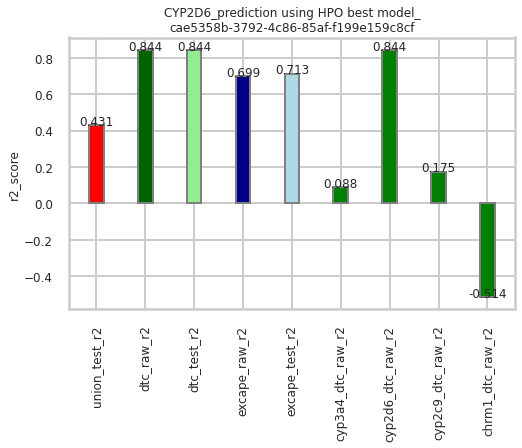

In [97]:
# plot
#sns.set_context('paper')
#import matplotlib.pyplot as plt
plt.rc('font', size=12)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=5)  # fontsize of the figure title
fig = plt.figure(figsize = (8,5))
datasets = ['union_test_r2', 'dtc_raw_r2', 'dtc_test_r2', 'excape_raw_r2', 'excape_test_r2','cyp3a4_dtc_raw_r2', 'cyp2d6_dtc_raw_r2', 'cyp2c9_dtc_raw_r2','chrm1_dtc_raw_r2']
r2scores = [union_test_r2, dtc_raw_r2, dtc_test_r2, excape_raw_r2, excape_test_r2, cyp3a4_dtc_raw_r2, cyp2d6_dtc_raw_r2, cyp2c9_dtc_raw_r2, chrm1_dtc_raw_r2]
plt.bar(datasets, r2scores, color=['red','darkgreen','lightgreen', 'darkblue', 'lightblue', 'green', 'green', 'green', 'green'], width=0.3, edgecolor='grey')
plt.ylabel("r2_score")
plt.title(target+"_prediction using HPO best model_\n"+model_uuid, fontsize=12)
for i in range(len(datasets)):plt.text(i, r2scores[i], r2scores[i], ha='center');
plt.xticks(rotation = 90) # Rotates X-Axis Ticks
plt.show()

# Confusion Matrix and visualization of predicted results

In [98]:
outdir

'/mnt/projects/ATOM/sarkart4/Data/HPO_models_CYP2D6_old/'

In [99]:
# read pred df - union test
pred_df = pd.read_csv(outdir+target+'union_test_pred_df_using_best_model.csv')
print(pred_df.shape)
pred_df.head(2)

(1843, 10)


,Unnamed: 0,base_rdkit_smiles,compound_id,pIC50,relation,active,pIC50_actual,pIC50_pred,pIC50_std,AD_index
0,0,S=C(Nc1ccc2cn[nH]c2c1)Nc1ccc2cn[nH]c2c1,OTJWJLLGPAFTIP-KNLWZTMUNA-N,5.7,NaN,1,5.7,5.143797,0.654045,1.429730
1,1,Cc1[nH]c2ccccc2c1C(c1ccccn1)N1CCC(C)CC1,NBKDMBGWUXYCJB-UHFFFAOYNA-N,4.6,<,0,4.6,5.243888,0.833574,2.197562


In [100]:
pred_df.pIC50_actual.describe()

count    1843.000000
mean        5.147879
std         0.775329
min         1.348527
25%         4.602060
50%         5.000000
75%         5.500000
max         9.000000
Name: pIC50_actual, dtype: float64

In [101]:
pred_df.pIC50_pred.describe()

count    1843.000000
mean        5.128650
std         0.448415
min         4.020329
25%         4.891172
50%         5.054979
75%         5.278692
max         7.693412
Name: pIC50_pred, dtype: float64

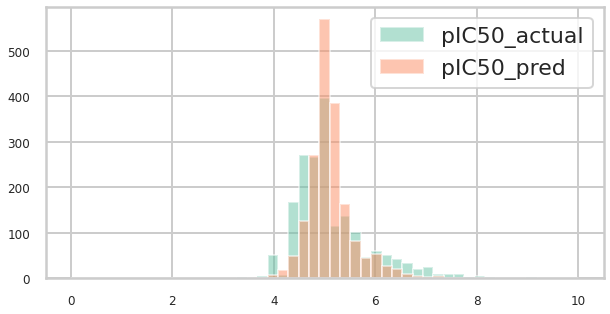

In [102]:
plt.figure(figsize=(10,5))
bins = np.linspace(0, 10, 50)
plt.hist(pred_df.pIC50_actual, bins, alpha=0.5, label='pIC50_actual')
plt.hist(pred_df.pIC50_pred, bins, alpha=0.5, label='pIC50_pred')
plt.legend(loc='upper right')
plt.show()

In [103]:
# # do we need to do this section?
# #-----------------------------------------------------------------------
# pred_df['censored']=pred_df[f'relation']
# pred_df.loc[pred_df.censored.isna(),'censored']='='
# relcat = CategoricalDtype(categories=["=","<", ">",], ordered=True)
# pred_df.censored=pred_df.censored.astype(relcat)
#-----------------------------------------------------------------------

In [104]:
# define catefories of prediction based on pIC50_std 
#add a new column category next to the pIC50_std. 
#category = pd.cut(pred_df.pIC50_std,bins=[0.00,0.42,0.55,0.64,1.44],labels=[0,1,2,3]) # labelled accordign to percentiles
#pred_df.insert(5,'categories',category)
#pred_df.categories

bin_values = [0,2,4,6,8,10]
pIC50_actual_category = pd.cut(pred_df.pIC50_actual,bins=bin_values,labels=[1,2,3,4,5])
# pred_df.insert(3,'pIC50_actual_category',pIC50_actual_category)
pred_df['pIC50_actual_category'] = pIC50_actual_category
pIC50_pred_category = pd.cut(pred_df.pIC50_pred,bins=bin_values,labels=[1,2,3,4,5])
# pred_df.insert(3,'pIC50_pred_category',pIC50_actual_category)
pred_df['pIC50_pred_category'] = pIC50_pred_category

In [105]:
pred_df[['pIC50_actual_category', 'pIC50_pred_category']]

,pIC50_actual_category,pIC50_pred_category
0,3,3
1,3,3
2,4,3
3,3,3
4,3,3
...,...,...
1838,3,3
1839,4,3
1840,3,3
1841,3,3


In [106]:
# Creating  a confusion matrix,which compares the y_test and y_pred
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(pred_df['pIC50_actual_category'], pred_df['pIC50_pred_category'])
cnf_matrix

array([[   0,    0,    2,    0,    0],
       [   0,    0,   52,    0,    0],
       [   0,    0, 1527,   19,    0],
       [   0,    0,  153,   83,    0],
       [   0,    0,    6,    1,    0]])

In [107]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cnf_matrix,
                     index = [1,2,3,4,5], 
                     columns = [1,2,3,4,5])
cm_df

,1,2,3,4,5
1,0,0,2,0,0
2,0,0,52,0,0
3,0,0,1527,19,0
4,0,0,153,83,0
5,0,0,6,1,0


<Figure size 720x360 with 0 Axes>

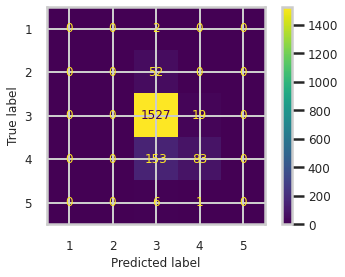

In [108]:
#Plotting the confusion matrix
from sklearn import metrics

plt.figure(figsize=(10,5))
plt.rc('font', size=12)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
# sns.heatmap(cm_df, annot=True)
# plt.title('Confusion Matrix')
# plt.ylabel('Actal Values')
# plt.xlabel('Predicted Values')
# plt.show()

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnf_matrix, display_labels = [1,2,3,4,5])

cm_display.plot()
plt.show()

In [109]:
from sklearn.metrics import classification_report
report = classification_report(pred_df['pIC50_actual_category'], pred_df['pIC50_pred_category'], 
                      labels=[1,2,3,4,5], digits=3, output_dict=True)
df = pd.DataFrame(report).transpose()
df

/home/sarkart4/miniconda3/envs/ampl-1.4.1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sarkart4/miniconda3/envs/ampl-1.4.1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sarkart4/miniconda3/envs/ampl-1.4.1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

,precision,recall,f1-score,support
1,0.000000,0.000000,0.000000,2.000000
2,0.000000,0.000000,0.000000,52.000000
3,0.877586,0.987710,0.929397,1546.000000
4,0.805825,0.351695,0.489676,236.000000
5,0.000000,0.000000,0.000000,7.000000
accuracy,0.873576,0.873576,0.873576,0.873576
macro avg,0.336682,0.267881,0.283815,1843.000000
weighted avg,0.839351,0.873576,0.842329,1843.000000


# Try different binning

#### Categorize 'pIC50_Actual' and 'pIC50_Pred' to 'active' or not. 

#### Please ignore previous 'active' and 'relation' column.

#### If pIC50 >= 5: active (1) else: Inactive (0). The threashold 5 is chosen based on scientific observation that compounds with pIC50 >=5 are highly likely to have drug properties. 

#### Two new columns are added: 'actual_binary_class' and 'pred_binary_class'. 


In [110]:
# I am generating 'active' column based on only pIC50 threashold 5
active_threshold = 5 
# Right inclusive=False implies pIC50 >=5 is active, else, inactive
cd.add_classification_column(thresholds=active_threshold, value_column='pIC50_actual', label_column='actual_binary_class', data=pred_df, right_inclusive=False)
cd.add_classification_column(thresholds=active_threshold, value_column='pIC50_pred', label_column='pred_binary_class', data=pred_df, right_inclusive=False)

,Unnamed: 0,base_rdkit_smiles,compound_id,pIC50,relation,active,pIC50_actual,pIC50_pred,pIC50_std,AD_index,pIC50_actual_category,pIC50_pred_category,actual_binary_class,pred_binary_class
0,0,S=C(Nc1ccc2cn[nH]c2c1)Nc1ccc2cn[nH]c2c1,OTJWJLLGPAFTIP-KNLWZTMUNA-N,5.700000,NaN,1,5.700000,5.143797,0.654045,1.429730,3,3,1.0,1.0
1,1,Cc1[nH]c2ccccc2c1C(c1ccccn1)N1CCC(C)CC1,NBKDMBGWUXYCJB-UHFFFAOYNA-N,4.600000,<,0,4.600000,5.243888,0.833574,2.197562,3,3,0.0,1.0
2,2,CC(C)(Cc1c[nH]c2ccc(Cl)cc12)NCCOc1ccccc1OCC1CC1,XLZHXAXXJVKTFM-UHFFFAOYNA-N,7.000000,NaN,1,7.000000,5.660848,0.923944,2.454029,4,3,1.0,1.0
3,3,CCN(CC)C(=O)CN1CCCC(c2nc3ccccc3n2Cc2ccc(F)cc2)C1,CHEMBL1935432,5.720831,NaN,1,5.720831,5.210171,0.489335,0.246560,3,3,1.0,1.0
4,4,NC(=NCc1ccc(Cl)cc1)SCCCc1c[nH]cn1,UCAIEVHKDLMIFL-QDYITYEQNA-N,4.900000,<,0,4.900000,5.249349,0.686501,2.114539,3,3,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838,1838,CCC(CCC(CC)NC(=O)C(NC(=O)N(C)Cc1csc(C(C)C)n1)C...,RXURCMJQURPYAA-JTAQYXEDSA-N,5.187087,NaN,1,5.187087,5.316523,0.470811,0.000001,3,3,1.0,1.0
1839,1839,CC(C)(C)c1ccc(SCC(c2ccccn2)c2cnc[nH]2)cc1,UNQMLUWBMWGIRY-UHFFFAOYSA-N,6.086186,NaN,1,6.086186,5.499550,0.687560,1.300730,4,3,1.0,1.0
1840,1840,Cc1c(NC(=O)OC[C@@H]2COCCN2)cn2ncnc(Nc3ccc4c(cn...,CHEMBL1645462,4.397940,<,0,4.397940,4.634213,0.698343,2.661888,3,3,0.0,0.0
1841,1841,Cc1cccc(CNc2cc(-c3ccoc3)ncn2)c1,ULRGIOOICJQYLZ-HCKMINDGNA-N,4.600000,<,0,4.600000,4.740827,0.250607,0.375060,3,3,0.0,0.0


In [111]:
pred_df.actual_binary_class.value_counts()

1.0    952
0.0    891
Name: actual_binary_class, dtype: int64

In [112]:
pred_df.pred_binary_class.value_counts()

1.0    1125
0.0     718
Name: pred_binary_class, dtype: int64

In [113]:
# Creating  a confusion matrix,which compares the actual_binary_class and pred_binary_class
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(pred_df['actual_binary_class'], pred_df['pred_binary_class'])
cnf_matrix

array([[541, 350],
       [177, 775]])

<Figure size 720x360 with 0 Axes>

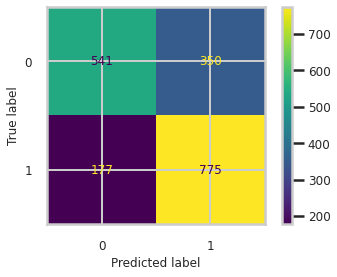

In [114]:
#Plotting the confusion matrix
from sklearn import metrics
plt.figure(figsize=(10,5))
plt.rc('font', size=12)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnf_matrix)#, display_labels = )
cm_display.plot()
plt.show()

In [115]:
from sklearn.metrics import classification_report
report = classification_report(pred_df['actual_binary_class'], pred_df['pred_binary_class'], digits=3, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
0.0,0.753482,0.607183,0.672467,891.000000
1.0,0.688889,0.814076,0.746269,952.000000
accuracy,0.714053,0.714053,0.714053,0.714053
macro avg,0.721185,0.710629,0.709368,1843.000000
weighted avg,0.720116,0.714053,0.710589,1843.000000


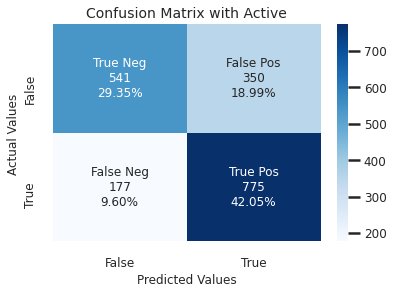

In [116]:
# ust a better representation!
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cnf_matrix.flatten()/np.sum(cnf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with Active',fontsize=14);
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [117]:
# get FP compounds
X_test = pred_df
y_test = pred_df['actual_binary_class']
y_pred = pred_df['pred_binary_class']

# get compounds for False Positive where actual class is 1 and predicted class is 0
FP_1 = X_test[(y_test == 1) & (y_pred == 0)]

# get compounds for False Positive where actual class is 0 and predicted class is 1
FP_0 = X_test[(y_test == 0) & (y_pred == 1)]
[len(FP_1), len(FP_0)]
FP_1

,Unnamed: 0,base_rdkit_smiles,compound_id,pIC50,relation,active,pIC50_actual,pIC50_pred,pIC50_std,AD_index,pIC50_actual_category,pIC50_pred_category,actual_binary_class,pred_binary_class
24,24,N/C(=N\c1ccc2c(c1)CCN2C1CCNCC1)c1cccs1,BLZNLOLTHDUEOL-WVGMYIGGNA-N,6.12494,NaN,1,6.12494,4.855591,0.863832,0.825559,4,3,1.0,0.0
25,25,N#Cc1ccc(CN2CC[C@@]3(CCCN(C(=O)Oc4ccccc4)C3)C2...,DQMIAVFBQMCSQL-QHCPKHFHNA-N,5.50000,NaN,1,5.50000,4.935152,0.461913,0.262888,3,3,1.0,0.0
31,31,CCCCCCCC/C=C\CCCCCCCC(=O)NCc1ccc(O)c(OC)c1,OPZKBPQVWDSATI-QMTUQTLUNA-N,5.50000,NaN,1,5.50000,4.567990,0.445678,0.160099,3,3,1.0,0.0
43,43,COc1cccc(CN(CCN2CCOCC2)C(=O)Nc2ccc(-c3cn[nH]c3...,GQMCGRYPKMDMGV-JJFURXLTNA-N,5.60000,NaN,1,5.60000,4.875632,0.646032,0.856746,3,3,1.0,0.0
47,47,O=c1[nH]c(-c2ccc(OCc3ccc(F)cc3F)cc2)nc2ccccc12,CHEMBL4084413,5.00000,<,0,5.00000,4.941072,0.501968,1.272576,3,3,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,1778,COc1ccc(CNc2ncncc2-c2cccc(C#N)c2)c(OC)c1,ZZEABKJZGWFGAG-MPIMZMORNA-N,5.30000,NaN,1,5.30000,4.999319,0.331269,0.000001,3,3,1.0,0.0
1799,1799,Cc1cc2nc(C3CCCN(C(=O)NCc4ccccc4)C3)[nH]c2cc1C,ZIKFGGUCAYDDAI-DVIAZDKANA-N,5.30000,NaN,1,5.30000,4.985725,0.541876,2.125144,3,3,1.0,0.0
1820,1820,O=C(OCC12CCN(CC1)CC2)c1c[nH]c2cc(F)ccc12,CHEMBL3951269,5.00000,<,0,5.00000,4.992068,0.283585,0.000001,3,3,1.0,0.0
1827,1827,O=C1CC2(CCCC2)CC(=O)N1CCCCN1CCN(c2ncccn2)CC1,QWCRAEMEVRGPNT-UHFFFAOYNA-N,5.00000,NaN,1,5.00000,4.942748,0.539041,1.525269,3,3,1.0,0.0


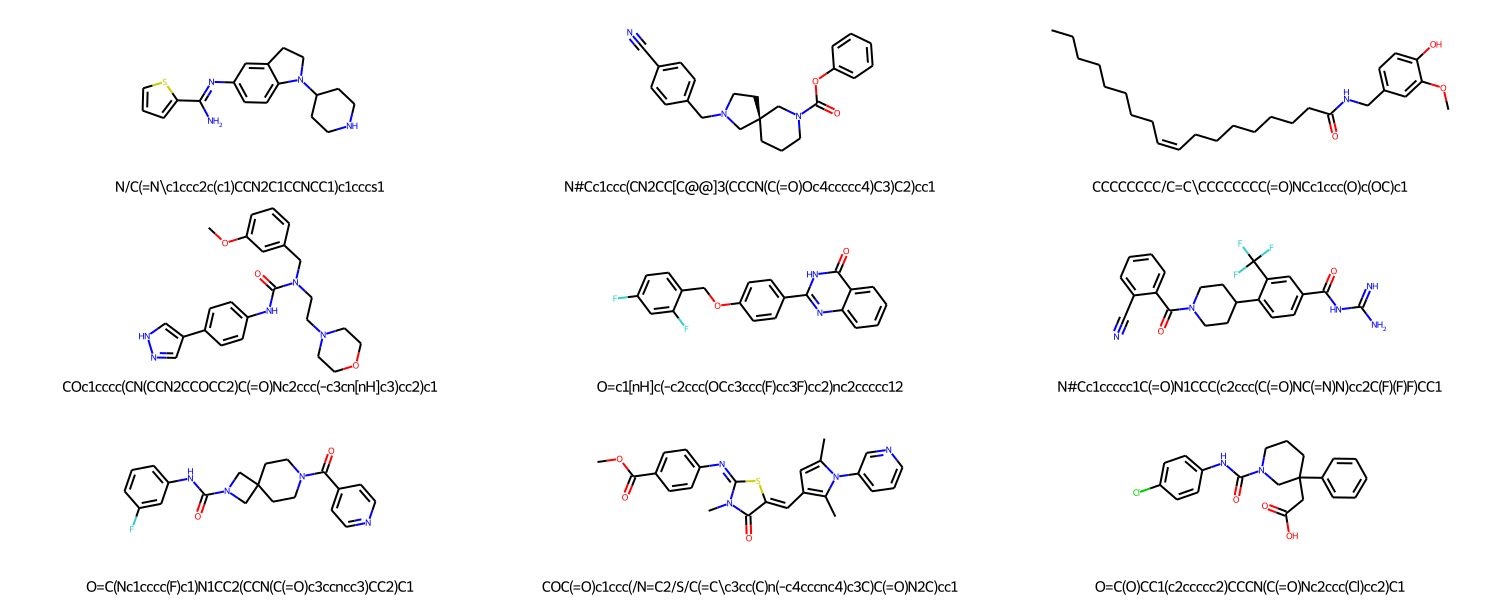

In [118]:
# visualize False Positive compounds
from rdkit import Chem
FP_1_smiles = FP_1['base_rdkit_smiles'].to_list()[:9]
FP_1_mols = [Chem.MolFromSmiles(smiles) for smiles in FP_1_smiles]
Chem.Draw.MolsToGridImage(FP_1_mols, molsPerRow=3, legends=FP_1['base_rdkit_smiles'].to_list()[:9], subImgSize=(500,200))

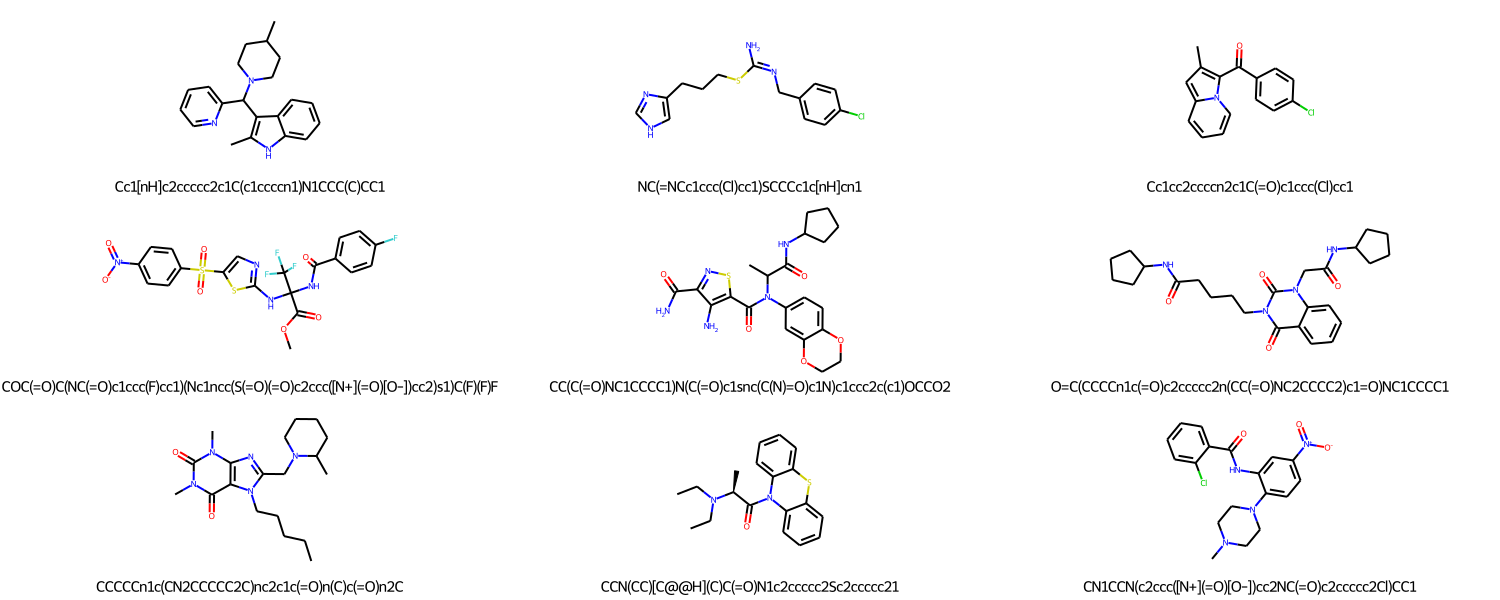

In [119]:
# visualize False Positive compounds
from rdkit import Chem
FP_0_smiles = FP_0['base_rdkit_smiles'].to_list()[:9]
FP_0_mols = [Chem.MolFromSmiles(smiles) for smiles in FP_0_smiles]
Chem.Draw.MolsToGridImage(FP_0_mols, molsPerRow=3, legends=FP_0['base_rdkit_smiles'].to_list()[:9], subImgSize=(500,200))